In [207]:
"""Setup and preproccessing"""
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

torch.manual_seed(11)
ticker = 'AAPL'
start_date = '2022-07-01'
end_date = '2025-10-31'

data = yf.download(ticker, start=start_date, end=end_date)
df = pd.DataFrame(data['Close'])

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

#convert into column matrix
data_tensor = torch.FloatTensor(df_scaled).view(-1)

[*********************100%%**********************]  1 of 1 completed


In [208]:
"""Setting up data to input into LSTM model"""
def create_sequences(data, seq_length):
    """Pattern extraction over seq_length for a given dataset."""
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = torch.tensor(data[i:i+seq_length], dtype=torch.float32) 
        target = torch.tensor(data[i+seq_length:i+seq_length+1], dtype=torch.float32) #single value for the sequence to learn direction towards
        sequences.append(seq)
        targets.append(target)
    return torch.stack(sequences), torch.stack(targets).view(-1)

sequence_length = 10
train_size = len(df_scaled) 
train_data= df_scaled[0:train_size]

X_train, y_train = create_sequences(train_data, sequence_length)

In [209]:
"""Model and parameter setup"""
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=35, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [210]:
"""Training model"""
epochs = 75

for epoch in range(epochs):
    for seq, labels in zip(X_train, y_train):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)
        labels = labels.view_as(y_pred)

        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()

#train
model.eval()
train_predictions = []
for seq in X_train:
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        train_predictions.append(model(seq).item())

train_predictions = scaler.inverse_transform(np.array(train_predictions).reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.numpy().reshape(-1, 1))

Train RMSE: 4.81
2024-03-04: 180.611 
2024-03-05: 181.741 
2024-03-06: 182.679 
2024-03-07: 183.691 
2024-03-08: 184.791 
2024-03-11: 185.890 
2024-03-12: 186.867 
2024-03-13: 187.669 
2024-03-14: 188.212 
2024-03-15: 188.458 
2024-03-18: 188.376 
2024-03-19: 187.983 
2024-03-20: 187.334 
2024-03-21: 186.500 
2024-03-22: 185.569 
2024-03-25: 184.635 
2024-03-26: 183.785 
2024-03-27: 183.084 
2024-03-28: 182.580 
2024-03-29: 182.298 
2024-04-01: 182.243 
2024-04-02: 182.405 
2024-04-03: 182.758 
2024-04-04: 183.268 
2024-04-05: 183.889 


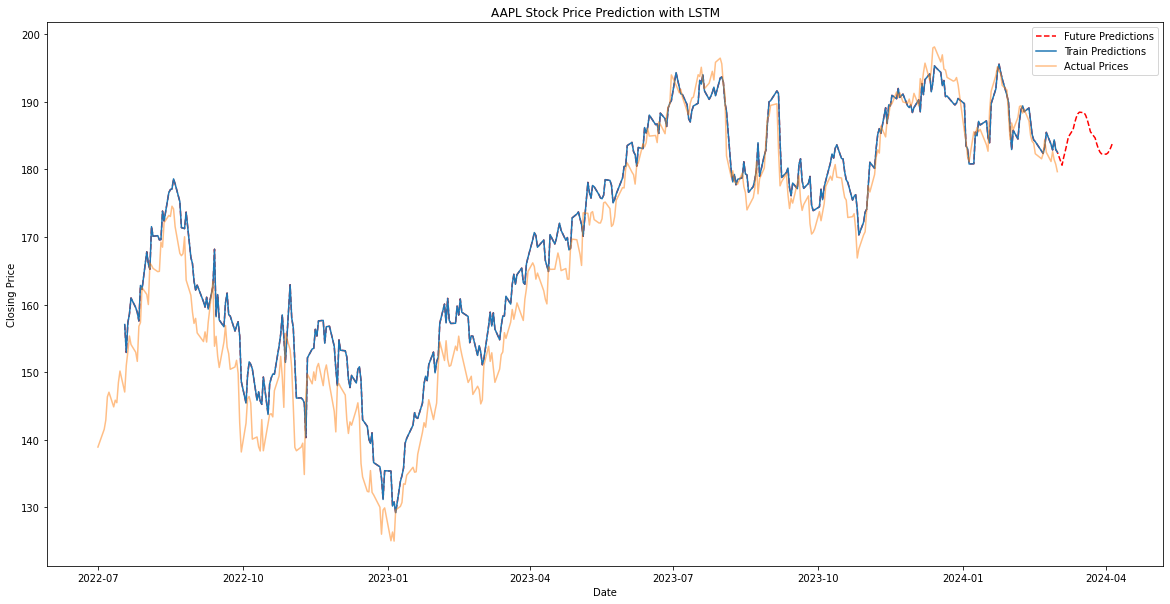

In [211]:
"""Computes predicted future sequences."""
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predictions))
print(f"Train RMSE: {train_rmse:.2f}")

def predict_future(model, initial_sequence, num_steps):
    future_predictions = []

    with torch.no_grad():
        current_sequence = initial_sequence
        for _ in range(num_steps):
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                 torch.zeros(1, 1, model.hidden_layer_size))
            next_pred = model(current_sequence)
            future_predictions.append(next_pred.item())
            current_sequence = torch.cat((current_sequence[1:], next_pred.view(1, 1)), dim=0)

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions


initial_sequence = torch.FloatTensor(train_data[-sequence_length:]) #using the raw training data 
num_future_steps = 25
future_predictions = predict_future(model, initial_sequence, num_future_steps)
future_dates = pd.date_range(df.index[-1], periods=num_future_steps + 1, freq='B')[1:]

for i,date in enumerate(future_dates):
    date = date.strftime('%Y-%m-%d')
    print(f'{date}: {future_predictions[i][0]:.3f} ')

all_dates = df.index.append(future_dates)
all_predictions = np.concatenate([train_predictions, future_predictions])

plt.figure(figsize=(20, 10))
plt.plot(all_dates[-len(all_predictions):], all_predictions, label='Future Predictions', linestyle='dashed', color='red')
plt.plot(all_dates[-len(all_predictions):-num_future_steps], all_predictions[:len(all_predictions)-num_future_steps], label='Train Predictions')
plt.plot(df.index, df['Close'], label='Actual Prices', alpha=0.5)

plt.title(f'{ticker} Stock Price Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()